In [26]:
import matplotlib.pyplot as plt
import numpy as np
import random

from transmitter import transmitter
from receiver import receiver

In [27]:
def success(a, b):
    """find the percentage difference between two lists"""
    successes = 0

    for index, i in enumerate(a):
        if i == b[index]:
            successes += 1 / len(a)

    return successes

### Transmitter

Chirp_p_s Prefix Length: 1024
Chirp_p_s Suffix Length: 1024
Chirp_p_s Length: 67568
LDPC Encoding Length: 30712
LDPC Padding Length: 392
[0 1 1 0 0 1 1 0 0 1]
OFDM Encoding Length: 62208
OFDM Padding Length: 0
[-1.+1.j  1.-1.j -1.+1.j  1.-1.j -1.+1.j]
watermark [3 2 3 3 2]


c:\Users\kmc07\OneDrive\Desktop\GF3_2\GF3\ldpc_jossy\transmitter.py:106: ComplexWarning: Casting complex values to real discards the imaginary part
  to_transmit[index]  = np.concatenate((cyclic_prefix, x), axis = None)


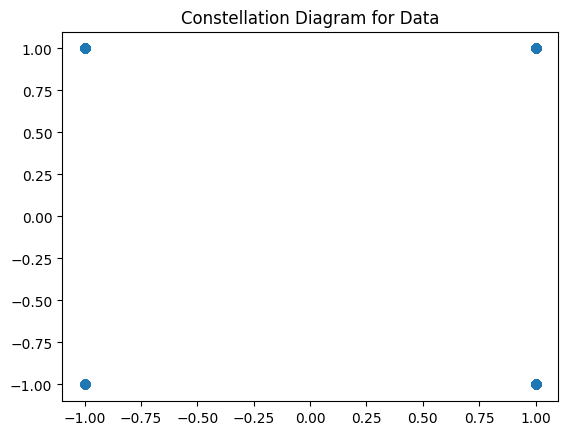

[0 1 0 0 0 0 0 1 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0
 0 1 0 0 1 1 0 0 1 0 0 0 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1 0 0
 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0 1 1 1 1 0 0 1 0]


In [28]:
t = transmitter()

# to_transmit = t.transmit("max_test_in.txt")
# # N.B. I think my gray coding method is v. slow(?)

binary_data = t.process_file("max_test_in.txt")
"""print(binary_data[0+648:10+648])"""
ldpc_encoded = t.ldpc_encode(binary_data)
print(ldpc_encoded[0+648*2:10+648*2])
to_transmit = t.ofdm(ldpc_encoded)
print(t.constellation[0+648:5+648])
print("watermark", t.generate_known_ofdm_block_mod4()[84:84+5] )
plt.scatter(t.constellation[0:500].real, t.constellation[0:500].imag)
plt.title("Constellation Diagram for Data")
plt.show()

print(binary_data[0:100])


### Simulated Channel

In [29]:
channel_response = np.loadtxt('../weekend_files/channel.csv', delimiter = ",", dtype = "float")

to_decode = np.convolve(channel_response, to_transmit)

to_decode = to_decode[:-1 * len(channel_response) + 1]

# NOISE

for index, i in enumerate(to_decode):
    to_decode[index] = i + random.gauss(0.0, 0.0)

### Decoder

In [36]:
r = receiver()

# Set channel estimation by hand:

channel_response = np.loadtxt('../weekend_files/channel.csv', delimiter = ",", dtype = "float")
r.channel_response_padded = np.pad(channel_response, (0, r.ofdm_symbol_size - len(channel_response)))
r.channel_freq = np.fft.fft(r.channel_response_padded)
d, llrs = r.ofdm_one_block(to_decode[1024+4096+1024:5120+4096+1024], 1)
received_constellation = r.constellations

# sigma2 = r.calculate_sigma2(received_constellation, ldpc_encoded[1024+r.ofdm_bin_min:1024+r.ofdm_bin_max + 1])
print("known", r.generate_known_ofdm_block_mod4()[84:84+5])
print(r.constellations[0:5])
print(t.constellation[648:648+5])

conste = r.constellations[0:648]
dec = []
for i in conste:
    if np.real(i) >= 0 and np.imag(i) >= 0:
        dec.append(1 + 1j)
    elif np.real(i) <= 0 and np.imag(i) >= 0:
        dec.append(-1 + 1j)
    elif np.real(i) <= 0 and np.imag(i) <= 0:
        dec.append(-1 - 1j)
    elif np.real(i) >= 0 and np.imag(i) <= 0:
        dec.append(1 - 1j)
dec = np.array(dec)
sigma2 = r.calculate_sigma2(r.constellations[0:648], dec)
d, llrs = r.ofdm_one_block(to_decode[1024+4096+1024:5120+4096+1024], sigma2)
#d, llrs = r.ofdm_one_block(to_decode[1024:5120], 0.12)
# print(len(to_decode[5121:9217+1024]))

# ldpc_decoded, llrs = r.ofdm(to_decode[5121:9217+1024], sigma2)
# decoded = r.ldpc_decoded(ldpc_decoded, llrs)

# text = r.decode_text(decoded)



# sigmas = [0.05, 0.1, 0.12, 0.135, 0.15, 0.165, 0.18, 0.2, 0.25]
# error_rates = []

# ldpc_coded, llrs = r.ofdm(to_decode, 0) # Again I think the gray coding is quite slow
# decoded = r.ldpc_decode(ldpc_coded, llrs, mode="hard")
# text = r.decode_text(decoded)

# print("Error rate (No LDPC)", 1 - success(ldpc_coded, ldpc_encoded))
# print("Error rate (w/ LDPC) - hard:", 1 - success(decoded, binary_data))

# for sigma2 in sigmas:
#     ldpc_coded, llrs = r.ofdm(to_decode, sigma2) # Again I think the gray coding is quite slow

decoded = r.ldpc_decode_one_block(d, llrs)
error = 0
for i in range(len(decoded)):
    if decoded[i] != binary_data[i+648]:
        error += 1

print("Error rate (w/ LDPC) - soft", error / len(decoded))
    
#     text = r.decode_text(decoded)

#     print("Error rate (w/ LDPC) - soft", 1 - success(decoded, binary_data))
#     error_rates.append(1 - success(decoded, binary_data))

# noise_estimator = []

# for index, i in enumerate(r.constellations[0]):

#     if np.real(t.constellation[index]) >= 0 and np.imag(t.constellation[index]) >= 0:
#         color='red'
#         noise_estimator.append(t.constellation[index] - i)
#     elif np.real(t.constellation[index]) <= 0 and np.imag(t.constellation[index]) >= 0:
#         color='blue'
#     elif np.real(t.constellation[index]) <= 0 and np.imag(t.constellation[index]) <= 0:
#         color='green'
#     elif np.real(t.constellation[index]) >= 0 and np.imag(t.constellation[index]) <= 0:
#         color='yellow'

#     plt.scatter(i.real, i.imag, color=color, alpha=0.5)

# plt.title("Received constellation diagram under simulated channel")
# plt.show()

# sigma2 = 0
# for i in noise_estimator:
#     sigma2 += (i.real**2 + i.imag**2) / len(noise_estimator)

# print(sigma2)


Chirp_p_s Prefix Length: 1024
Chirp_p_s Suffix Length: 1024
Chirp_p_s Length: 67568
Watermark:  [3 2 3 3 2]
known [3 2 3 3 2]
[-1.+1.j  1.-1.j -1.+1.j  1.-1.j -1.+1.j]
[-1.+1.j  1.-1.j -1.+1.j  1.-1.j -1.+1.j]
first guess sigma2: 0.7387178256405234
[-1.+1.j  1.-1.j -1.+1.j  1.-1.j -1.+1.j  1.-1.j -1.-1.j  1.+1.j -1.+1.j
 -1.-1.j]
---
[-0.39276555+1.06606239j  0.38708047-1.05848181j -0.38156676+1.05077941j
  0.37622748-1.04295891j -0.37106566+1.0350241j   0.36608421-1.02697888j
 -1.01882722-0.36128597j  1.01057318+0.3566737j  -0.35225004+1.0022209j
 -0.99377458-0.34801757j]
second guess sigma2 0.3693589
Watermark:  [3 2 3 3 2]
Error rate (w/ LDPC) - soft 0.0


In [31]:
plt.plot(sigmas, np.array(error_rates))
plt.xlabel("Sigma ^2 (noise)")
plt.ylabel("Bit Error Rate")
plt.title("BER post LDPC for initial BER of 0.065")

plt.show()

NameError: name 'sigmas' is not defined